In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU_Lag(nn.Module):
    def __init__(self, H_no, lag, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(lag+1, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V):
        #V is shape (batch, 50000, lag+1)

        rnn_out, _ = self.rnn(V) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        final = torch.sigmoid(lin_out.reshape(V.shape[0], V.shape[1]))
        
        return final



In [3]:
batch_size = 20
batch_length = 5000
H_no = 40
device = torch.device("cuda")
lag = 20

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/V_comb_pred_2ms.npy").reshape(-1,batch_length)
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/ap_true/V_ap_true_2ms.npy").reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spike_train_2ms.npy").reshape(-1,batch_length)

V-= np.mean(V)

V = torch.from_numpy(V)
S = torch.from_numpy(S)

V_lag = np.zeros((V.shape[0], V.shape[1], lag)) #(lag,1000,50000)
for i in range(lag):
    V_lag[:,i+1:,i] = V[:,:-i-1]

V_lag = torch.from_numpy(V_lag)
print(V_lag.shape)

torch.Size([1000, 5000, 20])


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V_lag_train = V_lag[:980].float()
V_lag_test = V_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GRU_Lag(H_no, lag, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

7601


In [6]:
score_list = []

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    batch_V = V_train[batch_idx].to(device)
    batch_V_lag = V_lag_train[batch_idx].to(device)
    
    batch_V_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    batch_V_in[:,:,0] = batch_V
    batch_V_in[:,:,1:] = batch_V_lag
    
    S_out = model(batch_V_in)
    loss = bce_criterion(S_out, batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        V_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        V_test_in[:,:,0] = V_test
        V_test_in[:,:,1:] = V_lag_test
        
        test_S_out = model(V_test_in)
        test_loss = bce_criterion(test_S_out, S_test).item()
        
        score_list.append(test_loss)
        print(i, test_loss)

<ipython-input-6-fa9b8d4e78eb>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.6799271702766418
49 0.015814529731869698
99 0.010771393775939941
149 0.00955272652208805
199 0.008831189014017582
249 0.00840676948428154
299 0.008100999519228935
349 0.007886828854680061
399 0.007714441977441311
449 0.007565416861325502
499 0.007448049262166023
549 0.007352606393396854
599 0.007237980607897043
649 0.007149619050323963
699 0.0070616560988128185
749 0.0069894492626190186
799 0.006921824999153614
849 0.006864894647151232
899 0.0068075889721512794
949 0.006751545239239931
999 0.006700534373521805
1049 0.006651103496551514
1099 0.006600016262382269
1149 0.006536354310810566
1199 0.006452236324548721
1249 0.006387369241565466
1299 0.0063299937173724174
1349 0.006206484045833349
1399 0.006180949974805117
1449 0.006110951770097017
1499 0.006125754211097956
1549 0.0061821904964745045
1599 0.006035512313246727
1649 0.005993602331727743
1699 0.005951886530965567
1749 0.005908911116421223
1799 0.005919457878917456
1849 0.005927014164626598
1899 0.005850217770785093
1949 0.005

15599 0.005663372576236725
15649 0.005632677581161261
15699 0.005539241712540388
15749 0.005480642430484295
15799 0.005583748687058687
15849 0.005563291255384684
15899 0.0055696978233754635
15949 0.005545621272176504
15999 0.005485936533659697
16049 0.005491481628268957
16099 0.005478594917804003
16149 0.005473708268254995
16199 0.005580631084740162
16249 0.005501038860529661
16299 0.005437218584120274
16349 0.005503691267222166
16399 0.005681072827428579
16449 0.005634766537696123
16499 0.005636392626911402
16549 0.0055351280607283115
16599 0.005478214472532272
16649 0.005519730504602194
16699 0.005521021783351898
16749 0.005617819260805845
16799 0.005572228692471981
16849 0.005505333188921213
16899 0.005593915935605764
16949 0.005544415209442377
16999 0.005548234563320875
17049 0.005549723282456398
17099 0.005688735283911228
17149 0.005503073800355196
17199 0.005588610656559467
17249 0.005565009545534849
17299 0.005488532595336437
17349 0.005526616703718901
17399 0.005574791226536035

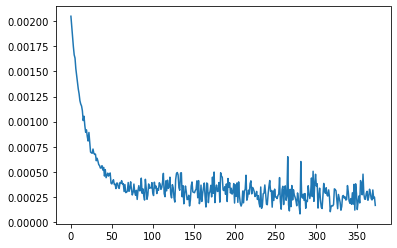

In [7]:
plt.plot(np.asarray(score_list)[20:])

tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


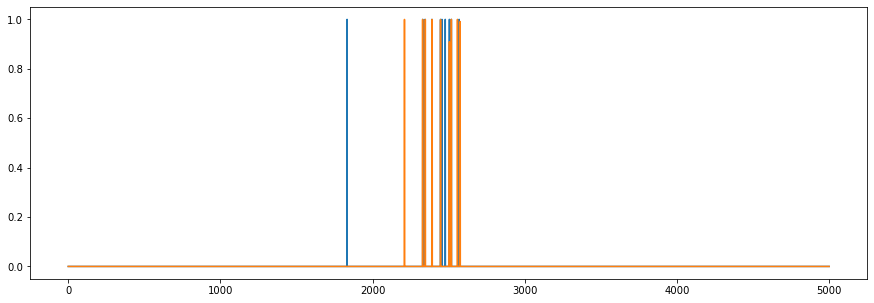

In [8]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy())
plt.plot(test_S_out[1].cpu().detach().numpy())
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))

In [9]:
torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_l20_h40_2ms.pt")
np.save("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_l20_h40_2ms_test.npy", test_S_out.cpu().detach().numpy())